# Auteur : PAMBOU MOUBOGHA Eddy Vianney
# Etudes : Master Sciences des Donnees et Systèmes Complexes
# Ecole : Université de Strasbourg
# Sujet :  Detection de glissements de terrain

In [7]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import csv
from datetime import date, datetime
import datetime
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.stattools import adfuller
import multiprocessing
import itertools
import operator
import math
from dtaidistance import dtw
import seaborn as sns
plt.style.use('fivethirtyeight')

# Attributs des fichiers MM_TIO

* Lat : latitude (degré)
* Lon : longitude (degré)
* Vel : vitesse (mètre/jour)
* Topo : altitude d'un point (mètre)
* TS : serie temporelles de déplacement (mètre)

In [3]:
DATA_PATH = './donnees'

# Paramètres des géométries ascendante et descendante

In [5]:
# angle d'incidence du satellite en géométrie ascendante (angle entre la vertical et la direction du  satellite)
theta_asc = 0
# angle d'incidence du satelitte en géométrie descendante (angle entre la vertical et la direction du satellite)
theta_desc = 0
# difference angulaire des orbites des géométries ascendante et descendante
delta_alpha =  0
# déplacement le long de la ligne de visée en géométrie ascendante
d_los_asc = 0
# déplacement le long de la ligne de visée en géométrie descendante
d_los_dsc = 0
# # déplacement vertical
d_up = 0

# Chargement des données

In [20]:
# chargement de la composante  Est-Ouest du mouvement du sol
df_ew, df_ew_ts = load_data('MM_TIO_EW_31TGK_20151227_to_20200906.csv')
# chargement de la composante Nord-Sud du mouvement du sol
df_ns, df_ns_ts = load_data('MM_TIO_NS_31TGK_20151227_to_20200906.csv')

In [111]:
def to_date(str):
    str_strp = str.strip()
    year, month, day = int(str_strp[0:4]), int(str_strp[4:6]), int(str_strp[6:8])
    return date(year, month, day)

def load_data(filename):

    # numéro de la ligne ou commence les données
    num_start = 44
    # numéro de la ligne ou se trouve la liste des dates
    num_list_dates = 40
    # attributs présent dans les données
    columns = ['id', 'Lat','Lon', 'Topo', 'Vel', 'Coer',' CosN', 'CosE', 'CosU']
    # dictionnaire stockant les données
    data = {column: [] for column in columns}
    # liste des dates 
    indexes = []
    # series temporelles
    series = []
    # liste de dataframes
    df_series = []

    with open(DATA_PATH + '/' + filename) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=",")
        line_count = 1 
        for row in csv_reader:
            if line_count == num_list_dates:
                indexes = [row[0].split(' ')[1]] + row[1:]
            if line_count >= num_start:
                # extraction des premiers attributs
                for i in range(len(columns)):
                    data[columns[i]].append(row[i])
                # extraction de l'attribut TS(série temporelle)
                series.append([float(v) for v in row[len(columns):]])
            line_count  += 1
        if len(indexes) != len(series[0]):
            print('Erreur : Les indexes et les valeurs ne correspondent pas')
        # convertir les index en date
        indexes = [d.strip()[0:8] for d in indexes]
        # créer une liste de dataframes, chacun contenant une série temporelle
        for serie in series:
            tmp_serie = pd.DataFrame({'displacement': pd.Series(serie, index=pd.DatetimeIndex(indexes))})
            tmp_serie.sort_index(inplace=True)
            df_series.append(tmp_serie)
        # creer un dataframe pour les autres attributs
        df = pd.DataFrame(data)
        for column in df.columns:
            df[column] = pd.to_numeric(df[column], errors='coerce')
        df.set_index('id')
        
    return df, df_series


def get_ids(df, column='id'):
    
    return df[column].tolist()
        
def impute(series, ids, pc=0.4):
    
    result = []
    ids_to_not_keep = []
    n_samples = len(series[0])
    
    for i in range(len(series)):
        if 100*(series[i].isnull().sum().sum()/n_samples) < pc:
            result.append(series[i].interpolate(limit_direction='both', inplace=False))
        else:
            ids_to_not_keep.append(ids[i])
            
    return result, ids_to_not_keep

def imputed(serie, index=None):
    
    # dataframe resultat
    result = None
    
    # liste des identifiants des valeurs manquantes
    rows_with_nan = [index for index, row in serie.iterrows() if row.isnull().any()]
    
    if index is None:
        result = serie.dropna(inplace=False)
        
    if isinstance(index, list):
        pass
        
    return result, rows_with_nan
        

# imputer les données
def impute_(ns_series, ew_series, pc=0.4):

    # nombre de mésures
    n = len(ns_series[0])
    
    # recupérer les series de la composante Nord-Sud qui ont un pourcentage de valeurs manquuantes inferieur à 50%
    ns_booleans  = [True if (ns_series[i].isnull().sum().sum()/n) < pc else False for i in range(len(ns_series))]
    # recupérer les series de la composante Est-Ouest qui ont un pourcentage de valeurs manquuantes inferieur à 50%
    ew_booleans  = [True if (ew_series[i].isnull().sum().sum()/n) < pc else False for i in range(len(ew_series))]
    # Conserver uniquement les points où la norme du vecteur vitesse est calculable
    booleans     = [True if i and j else False for i, j in zip(ns_booleans, ew_booleans)]
    
    # suppression des séries temporelles qui ont un pourcentage de valeurs manquantes supérieure ou égale à 0.5
    ns_series_c = [d for d in itertools.compress(ns_series, booleans)]
    ew_series_c = [d for d in itertools.compress(ew_series, booleans)]
    
    # interpoler les valeurs manquantes des les séries restantes
    for i in range(len(ns_series_c)):
        if ns_series_c[i].isnull().sum().sum() > 0:
            ns_series_c[i].interpolate(limit_direction='both', inplace=True)
        if ew_series_c[i].isnull().sum().sum() > 0:
            ew_series_c[i].interpolate(limit_direction='both', inplace=True)
            
    return ns_series_c[0].index, ew_series_c, ns_series_c

In [186]:
class TimeSerie():
    
    def __init__(self, id_, lat, lon, topo, serie):
        self.id   = id_
        self.lat  = lat
        self.lon  = lon
        self.topo = topo
        self.serie = serie.copy()
    
    def load(self, displacement):
        return serie.dropna(inplace=False)
    
    def hasEnoughValues(self, pc):
        return True if 100*(self.serie.displacement.isnull().sum().sum()/len(self.serie)) < pc else False
        
    def normalize(self):
        return StandardScaler().fit_transform(self.serie)
        
    def compute_inst_vel(self):
        vels =  []
        for i in range(1, len(self.serie)-1):
            duration = (self.serie.index[i+1] - self.serie.index[i-1]).days
            displacement = self.serie.iloc[i+1].values[0] - self.serie.iloc[i-1].values[0]
            vels.append(displacement / duration)
        # supprimer le premier et le dernier index (formule non applicable)
        return pd.DataFrame(vels, index=self.serie.index[1:-1], columns=['vel'])
    
    def plot(self):
        pass
    
    def smooth(self, ampl=2):
        
        sigma = math.sqrt(self.serie.var())
        
        for i in range(len(self.serie)):
            if abs(self.serie.iloc[i].displacement) > ampl*sigma:
                # remplacer les anomalies par des valeurs manquantes
                self.serie.iloc[i, self.serie.columns.get_loc('displacement')]= np.nan
                
        # interpoler les valeurs manquantes pour lisser la série
        return self.serie.interpolate(limit_direction='both', inplace=False)
    
    def compute_adfuller(self, ts):
    
        adf_result = adfuller(ts)
        adf_output = pd.Series(adf_result[0:4],index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key, value in adf_result[4].items():
            adf_output['Critical Value (%s)'%(key)] = value

        return adf_output[1]

    def clone(self):
        return TimeSerie(self.id, self.lat, self.lon, self.topo, self.serie)
    
    def get_days(dates):
        days = []
        for i in range(len(dates)):
            days.append(abs((dates[0] - dates[i]).days ))
        return days

    def get_Xy(serie):
        X = get_days(serie.index)
        y = StandardScaler().fit_transform(serie)
        return np.array(X).reshape(-1,1), y

    # lorsque la regression est non significative (p-value > 0.05), on conclut que le déplacement
    # cumulé n'est pas une fonction linéaire du temps
    # On renvoie donc un dataFrame ne contenant que des valeurs nulles
    # Il est possible q'un résultat négatif soit l'effet du bruit
    # Un débruitage est donc nécessaire avant d'utiliser cette approche !
    def detect_non_moving_serie(alpha):
        X, y = get_Xy(self.displace)
        _, pval = f_regression(X,y)
        if pval > alpha:
            return pd.DataFrame(0.0, index=ts.index, columns=ts.columns)
        else:
            return ts

In [279]:
class DataFromImageCorrelation():
    
    def __init__(self, geo, ns, ew, pc=0.4, alpha=0.05):
        self.ns, self.ew  = self.load(geo, ns, ew, pc)
        self.n_cores = multiprocessing.cpu_count()
        self.magnitudes = []
        self.pc = pc
        self.alpha = alpha
    
    def remove(self):
        pass
    
    def load(self, geo, ns, ew, pc):
        ns_r, ew_r = [], []
        for i in range(len(ns)):
            # vérifier que les séries temporelles comporte un pourcentage de valeurs null inférieure à pc et on des id identiques
            if ns[i].isnull().sum().sum()/len(ns[i]) < pc:
                ns_r.append(TimeSerie(geo.iloc[i].id, geo.iloc[i].Lat, geo.iloc[i].Lon, geo.iloc[i].Topo, ns[i]))
                ew_r.append(TimeSerie(geo.iloc[i].id, geo.iloc[i].Lat, geo.iloc[i].Lon, geo.iloc[i].Topo, ew[i]))
        return ns_r, ew_r

    def compute_vel(self, ns_component, ew_component):
        return math.sqrt(ns_component * ns_component + ew_component * ew_component)
    
    def compute_magnitude(self, ns, ew):
        
        magnitudes = []
        
        ns_vel_ts = self.compute_inst_vels(ns)
        ew_vel_ts = self.compute_inst_vels(ew)
        
        for i in range(len(ns_vel_ts)):
            vels = []
            for ns_component, ew_component in zip(ns_vel_ts[i]['vel'], ew_vel_ts[i]['vel']):
                vels.append(self.compute_vel(ns_component, ew_component))
            df = pd.DataFrame(vels, index=ns_vel_ts[0].index, columns=['magnitude'])
            magnitudes.append(df)
            
        return magnitudes
            
    def compute_inst_vel(self, serie):
        vels =  []
        for i in range(1, len(serie.displacement)-1):
            duration = (serie.index[i+1] - serie.index[i-1]).days
            displacement = serie.iloc[i+1].values[0] - serie.iloc[i-1].values[0]
            vels.append(displacement / duration)
        # supprimer le premier et le dernier index (formule non applicable)
        return pd.DataFrame(vels, index=serie.index[1:-1], columns=['vel'])
    
    def compute_inst_vels(self, ts):
        
        with multiprocessing.Pool(self.n_cores) as p:
            results = p.map(self.compute_inst_vel, ts)
            return results
    
    # this is only for magnitudes
    def normalize(self, series):
        
        output = []
        for serie in series:
            tmp = StandardScaler().fit_transform(serie)
            tmp = tmp.reshape(len(tmp))
            output.append(tmp)
        return output
    
    # this is only for displacement !
    # cette méthode ne peut être appelée qu'une fois
    # cette méthode renvoie une liste de dataframe
    def smooth(self):
        ns_out_sm, ew_out_sm = [], []
        for n in range(len(self.ns)):
            ns_out_sm.append(self.ns[n].smooth())
            ew_out_sm.append(self.ew[n].smooth())
        return ns_out_sm, ew_out_sm
        
    def detect_non_moving_serie(self, serie, alpha):
        
        # transformer les index en durée pour pouvoire effectuer une regression linéaire
        X = np.array([abs((serie.index[0] - serie.index[n]).days) for n in range(len(serie.index))]).reshape(-1,1)

        # extraire la cible
        y = StandardScaler().fit_transform(serie)
        
        # calculer la p-value de la regression lineaire
        _, pval = f_regression(X,y.ravel())
            
        # eliminer le bruit si la regression n'est pas significative (bourrage de zeros)
        if pval > alpha:
            return pd.DataFrame(0.0, index=serie.index, columns=serie.columns)
        else:
            return serie
    
    # Les séries qui n'évoluent pas linéairement en fonction du temps,
    # seront remplacées par des séries nulles
    # cette méthode renvoie une liste de dataframes
    
    def detect_non_moving_series(self, ns, ew):
        ns_out, ew_out = [], []
        for n in range(len(ns)):
            ns_out.append(self.detect_non_moving_serie(ns[n], self.alpha))
            ew_out.append(self.detect_non_moving_serie(ew[n], self.alpha))
        return ns_out, ew_out

In [280]:
class Statistiques():
    
    def __init__(self):
        pass
    
    def get_days(self, dates):
        days = []
        for i in range(len(dates)):
            days.append(abs((dates[0] - dates[i]).days ))
        return days
    
    def get_Xy(self, serie):
        X = self.get_days(serie.index)
        y = StandardScaler().fit_transform(serie)
        return np.array(X).reshape(-1,1), y
    
    # lorsque la regression est non significative (p-value > 0.05), on conclut que le déplacement
    # cumulé n'est pas une fonction linéaire du temps
    # On renvoie donc un dataFrame ne contenant que des valeurs nulles
    # Il est possible q'un résultat négatif soit l'effet du bruit
    # Un débruitage est donc nécessaire avant d'utiliser cette approche !
    def detect_non_moving_serie(self, serie, alpha):
        X, y = get_Xy(serie)
        _, pval = f_regression(X,y)
        if pval > alpha:
            return pd.DataFrame(0.0, index=ts.index, columns=ts.columns)
        else:
            return ts
        
    def detect_non_moving_series(self, series):
        output = []
        for n in range(len(series)):
            output.append(self.detect_non_moving_serie(series[i]))
        return output
    

In [281]:
stats = Statistiques()

In [168]:
def compute_distances_matrix(series):
    
    # initialisation de la matrix des distances
    distances_matrix = np.zeros(shape=(len(series), len(series)))
    
    # calcul des distances et remplissage de la matrice de distance
    for n in range(len(series)):
        for m in range(n, len(series)):
            if n!=m:
                dist = dtw.distance(np.array(series[n]), np.array(series[m]))
                distances_matrix[n, m] = dist
                distances_matrix[m, n] = dist
            
    return distances_matrix

In [169]:
class Visualization():
    
    def __init__(self):
        pass
    
    def plot_displacement(self, ts):
        
        days = get_days(ns_ts.index)
        fig, ax = plt.subplots(figsize=(15,5))
    
        ax[0].plot(ns_ts['displacement'], color='blue', label='NS displacement (m)', marker='o', linewidth=2)
        ax[1].plot(ew_ts['displacement'], color='orange', label='EW displacement (m)', marker='o', linewidth=2)
        
        plt.legend()
        plt.legend(loc='best')
        plt.show()
    
    def plot_displacement_vel(self, ns_ts, ew_ts):
        
        days = get_days(ns_ts[0].index)

        fig, ax_left = plt.subplots(figsize=(15,5))
        ax_right = ax_left.twinx()

        p1, = ax_left.plot(days, df_series[4]['displacement'], color='blue', label='NS displacement (m)')
        p2, = ax_right.plot(days, df_series[4]['displacement'], color='orange', label='EW displacement(m)')

        ax_left.set_xlabel("number of days since the first measure")
        ax_left.set_ylabel("displacement")
        ax_right.set_ylabel("velocity")

        lns = [p1, p2]

        ax_left.legend(handles=lns, loc='best')
        fig.tight_layout()
        plt.show()
    
    
    def plot_disp_vel(self, ns_ts, ew_ts, vels):

        fig, ax = plt.subplots(3, 1, figsize=(15,10))

        ax[0].plot(ns_ts.displacement, color='blue', label='displacement (m)', marker='o', linewidth=2)
        ax[0].set_title('NS cumulative displacement')
        ax[0].set_xlabel('time')
        ax[0].set_ylabel('displacement')
        ax[0].legend()

        ax[1].plot(ew_ts.displacement, color='orange', label='displacement (m)', marker='o', linewidth=2)
        ax[1].set_title('EW cumulative displacement')
        ax[1].set_xlabel('time')
        ax[1].set_ylabel('displacement')
        ax[1].legend()

        ax[2].plot(vels.magnitude, color='green', label='velocity (m/day)', marker='o', linewidth=2)
        ax[2].set_title('Velocity magnitude')
        ax[2].set_xlabel('time')
        ax[2].set_ylabel('velocity')
        ax[2].legend()

        fig.tight_layout()
        plt.show()
        
    def plot_series(series, num_rows=4, num_cols=5, colormap='tab20'):
        
        plot_kwds = {'alpha' : 0.25, 's' : 10, 'linewidths':0}
        fig, axs = plt.subplots(num_rows, num_cols, figsize=(25,25))
        cmap = plt.get_cmap(colormap)
        colors = [cmap(i) for i in np.linspace(0,1,num_rows*num_cols)]

        for num_row in range(num_rows):
            for num_col in range(num_cols):
                if num_row*num_cols + num_col < len(series):
                    axs[num_row, num_col].plot(series[num_row*num_cols + num_col], color=colors[num_row*num_cols + num_col], marker='o', markerfacecolor='white')
                    #axs[num_row, num_col].set_title('serie: %s'%(self.names[num_row*num_cols + num_col].split('.')[0]))

        plt.show()

In [115]:
class Utility():
    
    def __init__(self):
        pass

    def get_season(self, date):
        
        for season in seasons:
            name  = season[0]
            start = season[1].replace(year=date.year)
            end   = season[2].replace(year=date.year)
            if start <= date <= end:
                return name
            
    def count_samples_per_season(self, dates):
    
        samples_per_season = {'winter': 0, 'spring': 0, 'summer': 0, 'autumn': 0}
        for date in dates:
            samples_per_season[get_season(date)] += 1

        return samples_per_season
    
    def get_days(self, dates):
        
        days = []
        for i in range(len(dates)):
            days.append(abs((dates[0] - dates[i]).days ))
        return days

In [238]:
def get_days(dates):
    days = []
    for i in range(len(dates)):
        days.append(abs((dates[0] - dates[i]).days ))
    return days

def get_Xy(serie):
    X = get_days(serie.index)
    y = StandardScaler().fit_transform(serie)
    return np.array(X).reshape(-1,1), y

# lorsque la regression est non significative (p-value > 0.05), on conclut que le déplacement
# cumulé n'est pas une fonction linéaire du temps
# On renvoie donc un dataFrame ne contenant que des valeurs nulles
# Il est possible q'un résultat négatif soit l'effet du bruit
# Un débruitage est donc nécessaire avant d'utiliser cette approche !
def detect_non_moving_point(ts, alpha):
    X, y = get_Xy(ts)
    _, pval = f_regression(X,y)
    if pval > alpha:
        return pd.DataFrame(0.0, index=ts.index, columns=ts.columns)
    else:
        return ts

In [295]:
n = 3000
Data = DataFromImageCorrelation(df_ew.head(n), df_ns_ts[:n], df_ew_ts[:n])

In [296]:
ns_sm, ew_sm = Data.smooth()

In [297]:
ns_nm, ew_nm = Data.detect_non_moving_series(ns_sm, ew_sm)

In [298]:
magnitudes = Data.compute_magnitude(ns_nm, ew_nm)

In [294]:
viz = Visualization()
n = 2500
viz.plot_disp_vel(Data.ns[n], Data.ew[n], Data.magnitudes[n])

IndexError: list index out of range

In [314]:
X, y = get_xy(Data.ew[n].displacement)
F, pval = f_regression(X,y)

print(pval[0])
if pval[0] < 0.05:
    print('regression significative')
else:
    print('regression non significative')

IndexError: list index out of range

# Visualisation 

In [313]:
#from datetime import datetime
Y = 2000
seasons  = [('winter', date(Y,  1,  1), date(Y,  3, 20)),
           ('spring', date(Y,  3, 21),  date(Y,  6, 20)),
           ('summer', date(Y,  6, 21),  date(Y,  9, 22)),
           ('autumn', date(Y,  9, 23),  date(Y, 12, 20)),
           ('winter', date(Y, 12, 21),  date(Y, 12, 31))]

        
def plot_pie(labels, values):

    fig1, ax1 = plt.subplots(figsize=(5,5))
    ax1.pie(values, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal') 

    plt.show()
    
def plot_displacement(ns_ts, ew_ts):
    
    days = get_days(ns_ts.index)
    fig, ax = plt.subplots(figsize=(15,5))
    
    ax.plot(ns_ts['displacement'], color='blue', label='NS displacement (m)', marker='o', linewidth=2)
    ax.plot(ew_ts['displacement'], color='orange', label='EW displacement (m)', marker='o', linewidth=2)
    
    plt.legend(loc='best')
    
def plot_displacement_velocity(ns_ts, ew_ts):

    days = get_days(ns_ts[0].index)

    fig, ax_left = plt.subplots(figsize=(15,5))
    ax_right = ax_left.twinx()

    p1, = ax_left.plot(days, df_series[4]['displacement'], color='blue', label='NS displacement (m)')
    p2, = ax_right.plot(days, df_series[4]['displacement'], color='orange', label='EW displacement(m)')

    ax_left.set_xlabel("number of days since the first measure")
    ax_left.set_ylabel("displacement")
    ax_right.set_ylabel("velocity")

    lns = [p1, p2]

    ax_left.legend(handles=lns, loc='best')
    fig.tight_layout()
    plt.show()

In [310]:
r = count_samples_per_season(df_ew_ts[0].index)
plot_pie(list(r.keys()), list(r.values()))

NameError: name 'count_samples_per_season' is not defined

In [14]:
# c is the attribute we'll map onto colors, s is the attribute we'll represent with circle size.
df_ns.plot(kind="scatter", x="Lat", y="Lon",
    s=df_ns['Topo']/1000, label="Elevation (m)",
    c="Vel", cmap=plt.get_cmap("jet"),
    colorbar=True, alpha=0.4, figsize=(10,7),
)
plt.legend()
plt.show()

NameError: name 'df_ns' is not defined

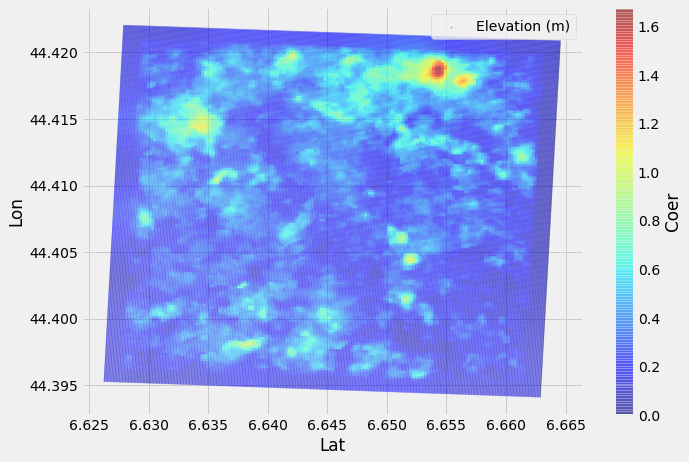

In [853]:
# c is the attribute we'll map onto colors, s is the attribute we'll represent with circle size.
df_ns.plot(kind="scatter", x="Lat", y="Lon",
    s=df_ns['Topo']/1000, label="Elevation (m)",
    c="Coer", cmap=plt.get_cmap("jet"),
    colorbar=True, alpha=0.4, figsize=(10,7),
)
plt.legend()
plt.show()

In [12]:
# on va rechercher la repartition des pics par saison en utilisant un critère statistique
def compute_anomalie_distribution(series):
    
    spikes = {'winter': 0, 'spring': 0, 'summer': 0, 'autumn': 0}
    
    for i in range(len(series)):
        l = get_spikeds(series[i])
        for j in range(len(l)):
            spikes[l[j]] += 1
            
    return spikes

## ST-DBSCAN

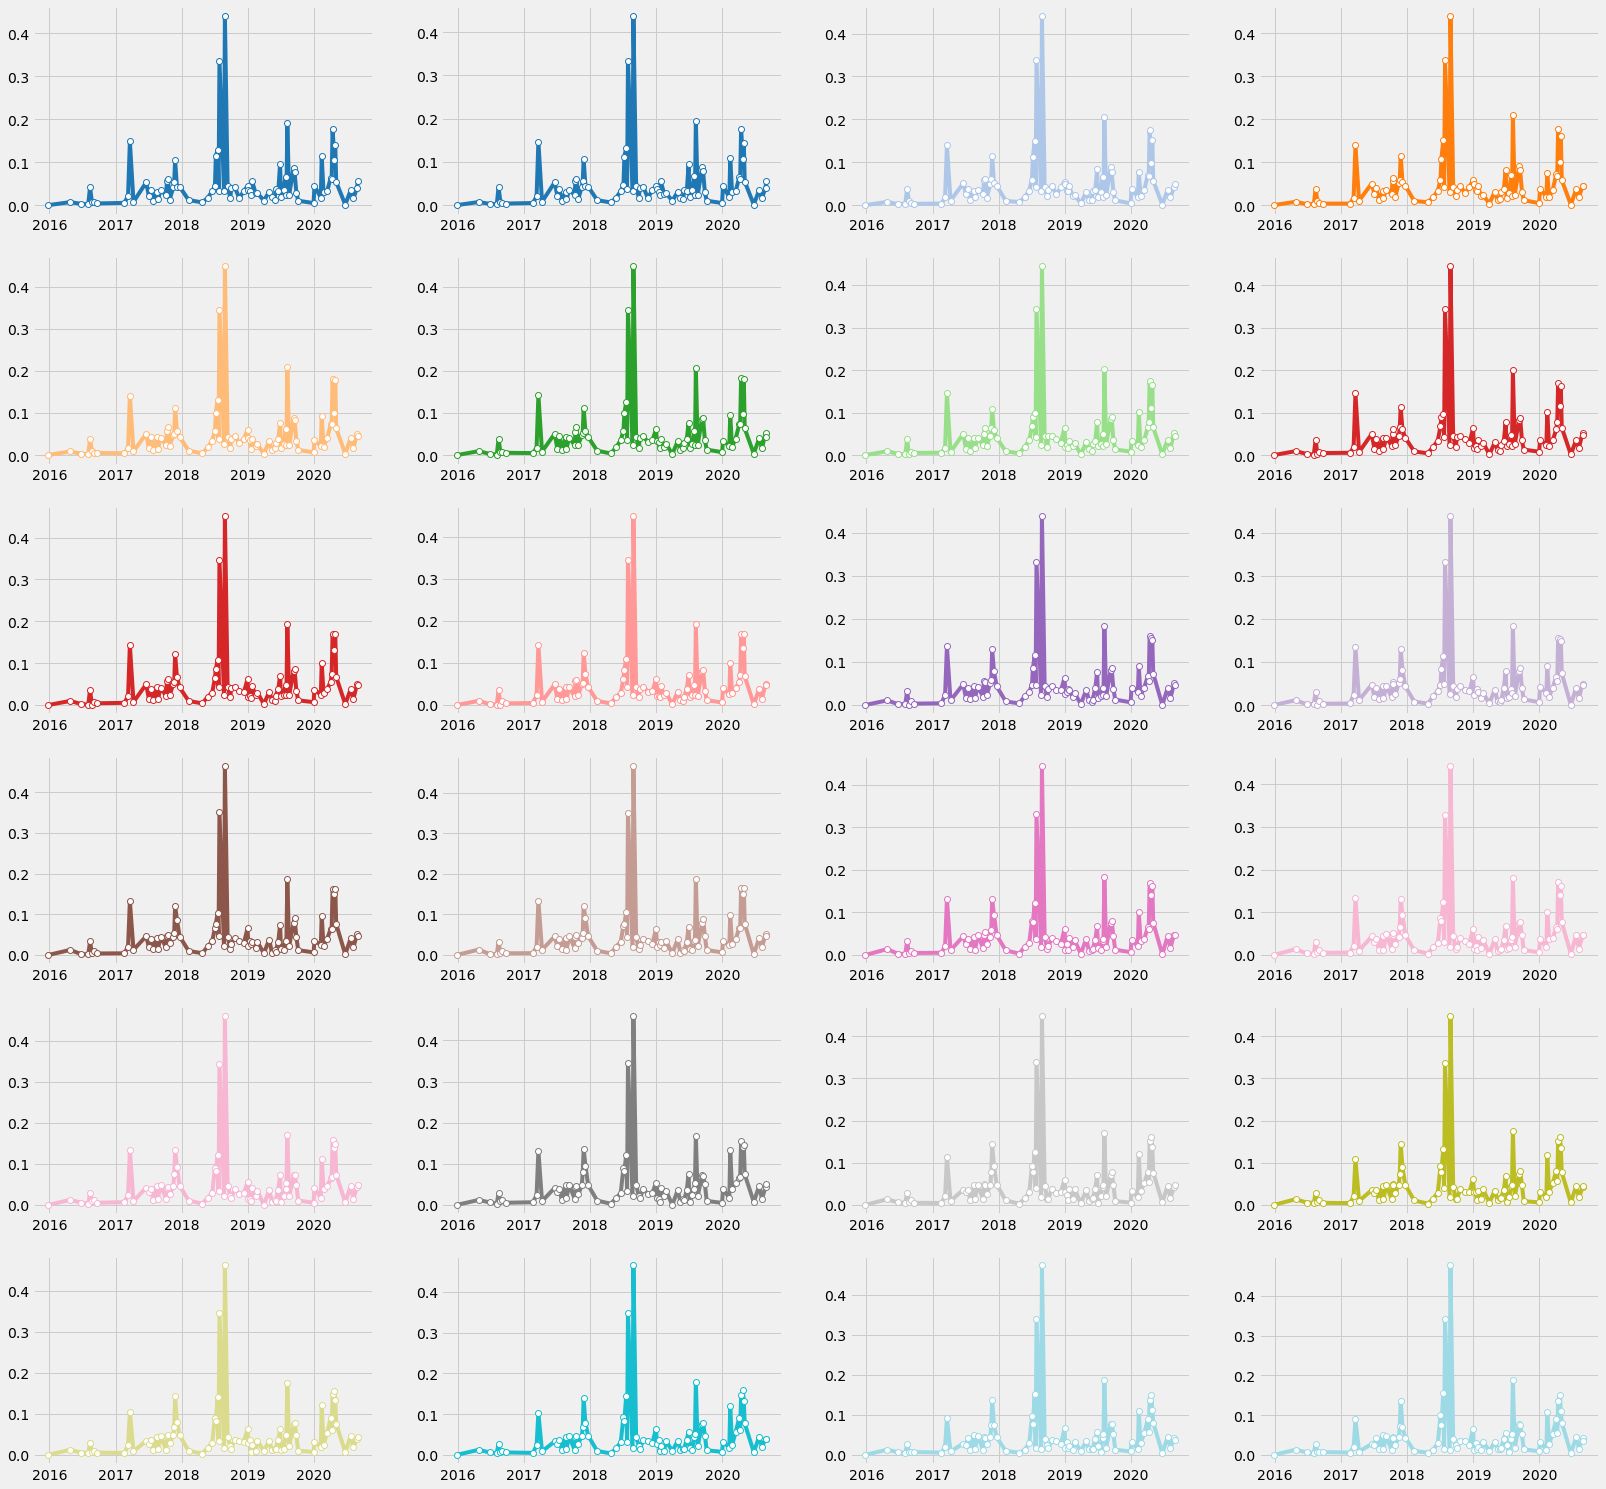

In [295]:
plot_series(get_data_from_class(vel_ts, clusterer.labels_, 2))

In [45]:
def plot_distribution(labels):
    
    v_count = dict()
    
    for label in labels:
        if label != -1:
            if label in v_count.keys():
                v_count[label] += 1
            else:
                v_count[label] = 1
            
    pd.Series({k: v for k, v in sorted(v_count.items(), key=lambda item: item[1])}).plot(kind='bar')
    
    return v_count
    
def get_data_from_class(series, labels, num_label):
    
    data = []
    
    for i in range(len(labels)):
        if labels[i] == num_label:
            data.append(series[i])
            
    return data

In [42]:
from sklearn.manifold import TSNE
import hdbscan

In [309]:
X = Data.normalize(Data.magnitudes)

projection = TSNE().fit_transform(X)

clusterer = hdbscan.HDBSCAN(min_cluster_size=10, gen_min_span_tree=True).fit(X)

color_palette = sns.color_palette('Paired', 12)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*projection.T, s=20, linewidth=0, c=cluster_member_colors, alpha=0.25)
plt.show()

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

{1: 904, 2: 38, 0: 32}

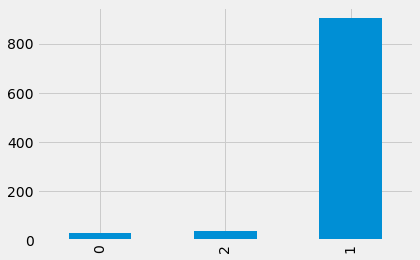

In [46]:
plot_distribution(clusterer.labels_)

## HDBSCAN

In [197]:
def plot_kmeans_clusters_shape(data, km, n_cols=3):
    
    n_rows = int(km.n_clusters / n_cols) if km.n_clusters % n_cols == 0 else int(math.ceil(km.n_clusters / n_cols))
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(25,15))

    for num_cluster in range(km.n_clusters):
        for serie_index in range(len(data)):
            if km.labels_[serie_index] == num_cluster:
                axs[int(num_cluster / n_cols), num_cluster % n_cols].plot(data[serie_index], c="gray", alpha=0.2)

        axs[int(num_cluster / n_cols), num_cluster % n_cols].plot(km.cluster_centers_[num_cluster].ravel(), "r-")
        axs[int(num_cluster / n_cols), num_cluster % n_cols].set_title('Cluster %d'%(num_cluster + 1))
        

## Kmeans

In [38]:
def compute_distances_matrix(series):
    
    # initialisation de la matrix des distances
    distances_matrix = np.zeros(shape=(len(series), len(series)))
    
    # calcul des distances et remplissage de la matrice de distance
    for n in range(len(series)):
        for m in range(len(series)):
            x = series[n]['velocity'].dropna(inplace=False)
            y = series[m]['velocity'].dropna(inplace=False)
            dist = dtw.distance(x, y)
            distances_matrix[n, m] = dist
                
    return distances_matrix

Si on ne s'interesse qu'à la forme des séries, il faut normaliser avant d'appliquer le clustering

# Classification des séries temporelles

In [37]:
# recherchons une source
# S = WX
transformer.components_.shape #(20, 87)
# calculons l'activité d'une source
source = np.dot(X, transformer.components_[0])
# passage de S à X
np.dot(transformer.mixing_[:,0], source)

NameError: name 'transformer' is not defined

In [30]:
from sklearn.datasets import load_digits
from sklearn.decomposition import FastICA

X, _ = load_digits(return_X_y=True)
transformer = FastICA(n_components=7, random_state=0)
X_transformed = transformer.fit_transform(X)
X_transformed.shape

/home/eost-user/miniconda3/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


(1797, 7)

## Décomposition en composantes indépendantes

# Significativité des régressions linéaires
* p-value : probabilité que la pente soit nulle
* Hypothèse nulle HO : la pente de la droite de regression est nulle  (vitesse moyenne non significative)
* si la p-value est inférieure à 0.05 alors l'hypothèse nulle est rejetée (vitesse moyenne est significative).

In [75]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from statsmodels.api import add_constant
import statsmodels.api as sm

In [90]:
def get_days(dates):
    days = []
    for i in range(len(dates)):
        days.append(abs((dates[0] - dates[i]).days ))
    return days

def get_xy(serie):
    X = get_days(serie.index)
    y = StandardScaler().fit_transform(serie)
    return np.array(X).reshape(-1,1), y

def compute_linear_regression(X,y):
    
    X_ = add_constant(X)
    mod = sm.OLS(y,X_)
    fii = mod.fit()
    
    return fii.params, fii.pvalues

def compute_slope(displacement, days):
    
    return  np.cov(displacement, days)[0][1] / np.var(np.array(days))

In [126]:
from sklearn.feature_selection import f_regression

In [133]:
X, y = get_xy(Data.ns[n].displacement)
u, v = compute_linear_regression(X,y)
F, pval = f_regression(X,y)
print(pval[0])
if pval[0] < 0.05:
    print('regression significative')
else:
    print('regression non significative')

0.08848269931149019
regression non significative


/home/eost-user/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [92]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X, y)
reg.coef_

array([[-0.00014407]])

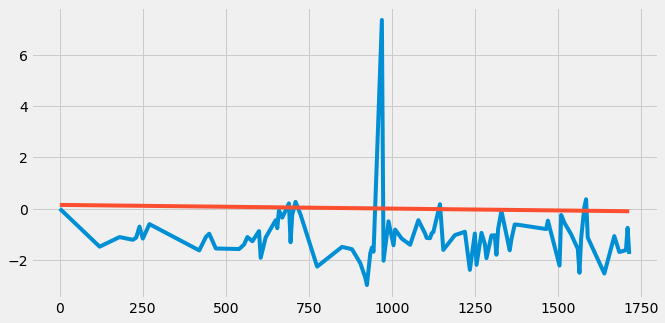

In [108]:
plt.figure(figsize=(10,5))
plt.plot(X, Data.ns[n].displacement)
coef = u[0]

y_pred = [reg.coef_[0][0]*x + reg.intercept_ for x in X]
plt.plot(X, y_pred)

In [95]:
non_stationary_series = []
for i in range(len(non_stationary_index)):
    non_stationary_series.append(df_series[non_stationary_index[i]])

NameError: name 'non_stationary_index' is not defined

In [ ]:
non_stationary_index = get_non_stationary(df_series)

In [81]:
def impute_time_series(serie):
    if serie.isnull().sum().sum() > 0:
        return serie.interpolate(limit_direction="both",inplace=False)
    else:
        return serie
    
def get_non_stationary(series, alpha=0.05, nb_nan_max=87):
    
    # nombre de series temporelles
    n_series = len(series)
    # liste contenant les indinces des séries temporelles non stationnaires
    non_stationary_series = []
    
    for i in range(len(series)):
        # imputer les series qui ont moins de nb_nan_max valeurs manquantes
        if series[i].isnull().sum().sum() < nb_nan_max: 
            serie = impute_time_series(series[i])
            result = adfuller(serie['displacement'])
            # le test de stationarité échoue automatiquement si la p-value est supérieure à 0.05
            if result[1] > alpha:
                non_stationary_series.append(i)
            
    return non_stationary_series

## Test de Dickey-Fuller augmenté (ADF)
La série temporelle est considérée comme stationnaire si la valeur p est faible (selon l’hypothèse nulle) et si les valeurs critiques à des intervalles de confiance de 1%, 5%, 10% sont aussi proches que possible des statistiques de l’ADF (Augmented Dickey-Fuller)

# Réechantillonage des données

# Etude de la saisonnalité

In [ ]:
import simplekml
kml=simplekml.Kml()
style = simplekml.Style()
style.labelstyle.color = simplekml.Color.red  
style.labelstyle.scale = 2
style.iconstyle.icon.href = 'http://maps.google.com/mapfiles/kml/shapes/placemark_circle.png'
for index, row in df.iterrows():
    kml.newpoint(name=row['Vel'], coords=[(row['Lat'], row['Lon'], row['Topo'])])
kml.save('ps.kml')  